# cluster_toolkit Module
The code use for DES cluster weak lensing now has a very clean UI that is nicely modularized for use in Python. This notebook has examples of how to use some of its functionality.

In [1]:
import cluster_toolkit
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rc("text", usetex=True)
plt.rc("font", size=18, family="serif")

In [2]:
#Starting from a power spectrum
#These can come from CAMB or CLASS or CCL or anything else
#They must be in units of Mpc/h comoving
klin = np.loadtxt("test_data/klin.txt")
Plin = np.loadtxt("test_data/plin.txt") #linear power spectrum
knl = np.loadtxt("test_data/knl.txt")
Pnl = np.loadtxt("test_data/pnl.txt") #nonlinear power spectrum

## Halo density profiles
This module has two halo density profiles available: the NFW profile and Einasto profiles. Here is how to calculate them.

In [3]:
#Set up the domain
NR = 1000
R = np.logspace(-2, 3, NR, base=10) #3D distance, Mpc/h comoving
Mass = 1e14 #Msun/h
conc = 5 #concentration
Omega_m = 0.3 #The only cosmological parameter we need, everything else is wrapped up in the power spectrum
#These two are einasto parameters
rs = 1.0 #Scale radius in Mpc/h comoving
a = 0.19 #Einasto exponent

In [4]:
rho_nfw = cluster_toolkit.density.rho_nfw_at_R(R, Mass, conc, Omega_m)
rho_ein = cluster_toolkit.density.rho_einasto_at_R(R, Mass, rs, a, Omega_m)

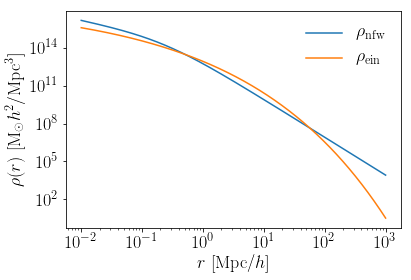

In [5]:
plt.loglog(R, rho_nfw,   label=r"$\rho_{\rm nfw}$")
plt.loglog(R, rho_ein,   label=r"$\rho_{\rm ein}$")
plt.xlabel(r"$r$ [Mpc/$h$]")
plt.ylabel(r"$\rho(r)\ [{\rm M_\odot}h^2/{\rm Mpc^3}]$")
plt.legend(loc=0, frameon=False)
#plt.subplots_adjust(bottom=0.18, left=0.15)
#plt.gcf().savefig("density_profile_example.png", dpi=500)

## Correlation functions
We can compute a variety of correlation functions. We can compute 1-halo terms (NFW, Einasto) and 2-halo terms (with/without bias) and combine them into halo-matter correlation functions.

In [6]:
#Set up the domain
NR = 1000
R = np.logspace(-2, 3, NR, base=10) #3D distance, Mpc/h comoving
Mass = 1e14 #Msun/h
conc = 5 #concentration
Omega_m = 0.3 #The only cosmological parameter we need, everything else is wrapped up in the power spectrum

In [7]:
#Calculate the halo bias for this halo
bias = cluster_toolkit.bias.bias_at_M(Mass, klin, Plin, Omega_m)
#Get all the correaltion functions
xi_nfw   = cluster_toolkit.xi.xi_nfw_at_R(R, Mass, conc, Omega_m)
xi_mm    = cluster_toolkit.xi.xi_mm_at_R(R, knl, Pnl)
xi_2halo = cluster_toolkit.xi.xi_2halo(bias, xi_mm)
xi_hm    = cluster_toolkit.xi.xi_hm(xi_nfw, xi_2halo)

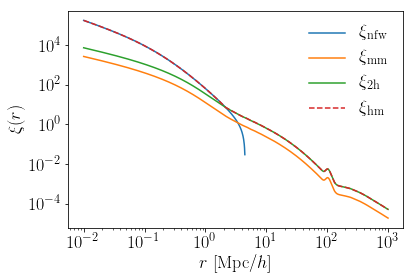

In [8]:
plt.loglog(R, xi_nfw,   label=r"$\xi_{\rm nfw}$")
plt.loglog(R, xi_mm,    label=r"$\xi_{\rm mm}$")
plt.loglog(R, xi_2halo, label=r"$\xi_{\rm 2h}$")
plt.loglog(R, xi_hm, ls='--', label=r"$\xi_{\rm hm}$")
plt.xlabel(r"$r$ [Mpc/$h$]")
plt.ylabel(r"$\xi(r)$")
plt.legend(loc=0, frameon=False)
#plt.subplots_adjust(bottom=0.18, left=0.15)
#plt.gcf().savefig("xi_example.png", dpi=500)

# Bias, $\sigma(M)$, $\nu$
The code can also calculate things like the bias, matter variance and peak height.

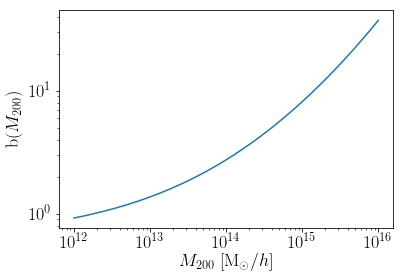

In [9]:
NM = 1000
Marr = np.logspace(12, 16, NM, base=10)
biases = cluster_toolkit.bias.bias_at_M(Marr, klin, Plin, Omega_m, delta=200)
plt.loglog(Marr, biases)
plt.xlabel(r"$M_{200}$ [M$_{\odot}/h$]")
plt.ylabel(r"b($M_{200}$)")
#plt.subplots_adjust(bottom=0.18, left=0.15)
#plt.gcf().savefig("bias_example.png", dpi=500)

# Surface density
It can calculate surface density $\Sigma(R)$ which can be used for magnification or $\Delta\Sigma(R)$ for shear. Both of these can be modified by different miscentering models.

In [10]:
Rp = np.logspace(-2, 2.4, NR, base=10)
Sigma  = cluster_toolkit.deltasigma.Sigma_at_R(Rp, R, xi_hm, Mass, conc, Omega_m)
Sigma_nfw = cluster_toolkit.deltasigma.Sigma_nfw_at_R(Rp, Mass, conc, Omega_m)

Rmis = 0.25 #Mpc/h; the miscentering length
Sigma_g2d  = cluster_toolkit.miscentering.Sigma_mis_at_R(Rp, Rp, Sigma, Mass, conc, Omega_m, Rmis)
Sigma_exp  = cluster_toolkit.miscentering.Sigma_mis_at_R(Rp, Rp, Sigma, Mass, conc, Omega_m, Rmis, kernel="exponential")
Sigma_single  = cluster_toolkit.miscentering.Sigma_mis_single_at_R(Rp, Rp, Sigma, Mass, conc, Omega_m, Rmis)

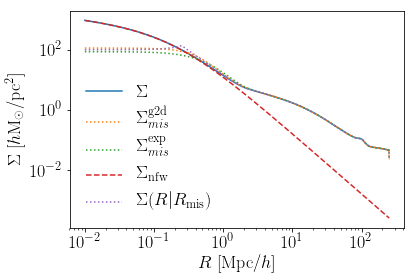

In [11]:
plt.loglog(Rp, Sigma, ls="-", label=r"$\Sigma$")
plt.loglog(Rp, Sigma_g2d, ls=":", label=r"$\Sigma_{mis}^{\rm g2d}$")
plt.loglog(Rp, Sigma_exp, ls=":", label=r"$\Sigma_{mis}^{\rm exp}$")
plt.loglog(Rp, Sigma_nfw, ls="--", label=r"$\Sigma_{\rm nfw}$")
plt.loglog(Rp, Sigma_single, ls=":", label=r"$\Sigma(R|R_{\rm mis})$")
plt.ylabel(r"$\Sigma$ [$h$M$_\odot$/pc$^2$]")
plt.xlabel(r"$R$ [Mpc/$h$]")
plt.legend(loc=0, frameon=False)
#plt.subplots_adjust(bottom=0.18, left=0.15)
#plt.gcf().savefig("Sigma_example.png", dpi=500)

# Differential surface mass density
The differential surface mass density $\Delta\Sigma$ is defined as
$$
\Delta\Sigma(R) = \bar{\Sigma}(<R) - \Sigma(R).
$$
This is why $R_p$ is passed in twice. First it is the domain of $\Delta\Sigma$ and then it is the domain of $\Sigma$.

In [12]:
DeltaSigma = cluster_toolkit.deltasigma.DeltaSigma_at_R(Rp, Rp, Sigma, Mass, conc, Omega_m)
DeltaSigma_nfw = cluster_toolkit.deltasigma.DeltaSigma_at_R(Rp, Rp, Sigma_nfw, Mass, conc, Omega_m)
DeltaSigma_g2d = cluster_toolkit.miscentering.DeltaSigma_mis_at_R(Rp, Rp, Sigma_g2d)
DeltaSigma_exp = cluster_toolkit.miscentering.DeltaSigma_mis_at_R(Rp, Rp, Sigma_exp)
DeltaSigma_single = cluster_toolkit.miscentering.DeltaSigma_mis_at_R(Rp, Rp, Sigma_single)

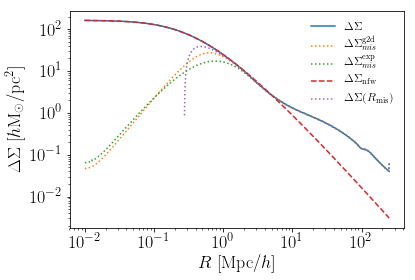

In [13]:
plt.loglog(Rp, DeltaSigma, ls="-", label=r"$\Delta\Sigma$")
plt.loglog(Rp, DeltaSigma_g2d, ls=":", label=r"$\Delta\Sigma_{mis}^{\rm g2d}$")
plt.loglog(Rp, DeltaSigma_exp, ls=":", label=r"$\Delta\Sigma_{mis}^{\rm exp}$")
plt.loglog(Rp, DeltaSigma_nfw, ls="--", label=r"$\Delta\Sigma_{\rm nfw}$")
plt.loglog(Rp, DeltaSigma_single, ls=":", label=r"$\Delta\Sigma(R_{\rm mis})$")
plt.xlabel(r"$R$ [Mpc/$h$]")
plt.ylabel(r"$\Delta\Sigma$ [$h$M$_\odot$/pc$^2$]")
plt.legend(loc=0, frameon=False, fontsize=12)
#plt.subplots_adjust(bottom=0.18, left=0.15)
#plt.gcf().savefig("DeltaSigma_example.png", dpi=500)

# Boost factors
The boost factor is the amount of dilution of the lensing signal because of cluster galaxies being mixed up in the source catalog. This is called the `boost factor` because one would noramlly use an estimate of this to boost or correct the $\Delta\Sigma$ data. Implemented in this repository is a module for $\mathcal{B}(R) = (1-f_{\rm cl})^{-1}$, or a boost factor model as a function of distance on the sky to the cluster center. At the moment there is only an NFW model implemented. This may change in the future.

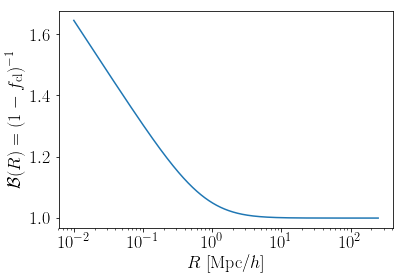

In [14]:
B0 = 0.15 #Typical NFW boost factor amplitude
Rs = 1.0 #Typical NFW boost factor scale radius, Mpc/h comoving
boost = cluster_toolkit.boostfactors.boost_nfw_at_R(Rp, B0, Rs)
plt.plot(Rp, boost)
plt.xscale('log')
plt.xlabel(r"$R$ [Mpc/$h$]")
plt.ylabel(r"$\mathcal{B}(R)=(1-f_{\rm cl})^{-1}$")
#plt.subplots_adjust(bottom=0.18, left=0.15)
#plt.gcf().savefig("boost_example.png", dpi=500)

# De-boosting the lensing
In DES, we treat the data as sacred. So instead of boosting the data and multiplying by $\mathcal{B}$, we divide $\mathcal{B}$ into the modeled $\Delta\Sigma$.

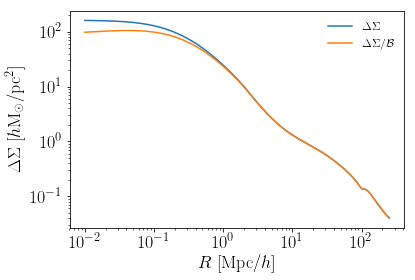

In [15]:
DeltaSigma = cluster_toolkit.deltasigma.DeltaSigma_at_R(Rp, Rp, Sigma, Mass, conc, Omega_m)
B0 = 0.15 #Typical NFW boost factor amplitude
Rs = 1.0 #Typical NFW boost factor scale radius, Mpc/h comoving
boost = cluster_toolkit.boostfactors.boost_nfw_at_R(Rp, B0, Rs)
DeltaSigma_deboosted = DeltaSigma/boost
plt.loglog(Rp, DeltaSigma, ls="-", label=r"$\Delta\Sigma$")
plt.loglog(Rp, DeltaSigma_deboosted, ls="-", label=r"$\Delta\Sigma/\mathcal{B}$")
plt.xlabel(r"$R$ [Mpc/$h$]")
plt.ylabel(r"$\Delta\Sigma$ [$h$M$_\odot$/pc$^2$]")
plt.legend(loc=0, frameon=False, fontsize=12)
#plt.subplots_adjust(bottom=0.18, left=0.15)
#plt.gcf().savefig("deboost_example.png", dpi=500)